In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.decomposition import PCA
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
import pandas as pd
import requests
import json
import sklearn
import nltk
import spacy
import string
from itertools import *
import matplotlib.pyplot as plt

In [2]:
def getAuthorTexts(author, n=10):
    response = requests.get(f"http://corpus-db.org/api/author/{author}/fulltext")
    if response.ok:
        decoded = json.loads(response.text)
        return [t['text'] for t in decoded[:n]]
    
def getAuthorMeta(author, n=10):
    response = requests.get(f"http://corpus-db.org/api/author/{author}")
    if response.ok:
        decoded = json.loads(response.text)
        return decoded[:n]
    
def getAuthorTitles(author):
    meta = getAuthorMeta(author)
    return [item['title'] for item in meta]

def getTitlesAndTexts(auth):
    return getAuthorTitles(auth), getAuthorTexts(auth)

collinsTitles, collinsTexts = getTitlesAndTexts('Collins, Wilkie')

moonstone = open('moonstone.md').read()
womanInWhite = collinsTexts[2]

In [3]:
# The Woman In White

hartright = (womanInWhite.split('\n\n\n\nTHE STORY ')[1] + 
             womanInWhite.split('\n\n\n\nTHE STORY ')[6].split('THE NARRATIVE OF')[5] +
             womanInWhite.split('\n\n\n\nTHE STORY ')[7] +
             womanInWhite.split('\n\n\n\nTHE STORY ')[9] +
             womanInWhite.split('\n\n\n\nTHE STORY ')[11])           
gilmore = womanInWhite.split('\n\n\n\nTHE STORY ')[2]
halcombe = womanInWhite.split('\n\n\n\nTHE STORY ')[3]
frederick = womanInWhite.split('\n\n\n\nTHE STORY ')[4]
michelson = womanInWhite.split('\n\n\n\nTHE STORY ')[5]
pinhorn = womanInWhite.split('\n\n\n\nTHE STORY ')[6].split('THE NARRATIVE OF ')[1]
doctor = womanInWhite.split('\n\n\n\nTHE STORY ')[6].split('THE NARRATIVE OF ')[2]
jane_gould = womanInWhite.split('\n\n\n\nTHE STORY ')[6].split('THE NARRATIVE OF ')[3]
catherick = womanInWhite.split('\n\n\n\nTHE STORY ')[8]
fosco = womanInWhite.split('\n\n\n\nTHE STORY ')[10].split('THE ')[1]

In [4]:
# The Moonstone

moonstone_narrators = moonstone.split('\n## ')
clack, bruff, jennings, cuff, candy = [moonstone_narrators[part] for part in [4, 5, 7, 9, 10]]
franklin = (moonstone_narrators[6] + ' ' + moonstone_narrators[8])
betteredge = (moonstone_narrators[2] + ' ' + moonstone_narrators[11])
allLabels = ["Clack", "Bruff", "Franklin", "Jennings", "Cuff", "Candy", "Betteredge"]
allTexts = [clack, bruff, franklin, jennings, cuff, candy, betteredge]

In [5]:
womenInWhite_male = [hartright, gilmore, frederick, doctor, fosco]
womenInWhite_female = [halcombe, michelson, pinhorn, jane_gould, catherick]

In [6]:
moonstone_male = [bruff, franklin, jennings, cuff, candy, betteredge]
moonstone_female = clack

In [7]:
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000


moonstoneDoc = nlp(moonstone)
moonstoneLocation = [ent for ent in moonstoneDoc.ents if ent.label_ == 'GPE']

In [8]:
womanInWhiteDoc = nlp(womanInWhite)
womanInWhiteLocation = [ent for ent in womanInWhiteDoc.ents if ent.label_ == 'GPE']

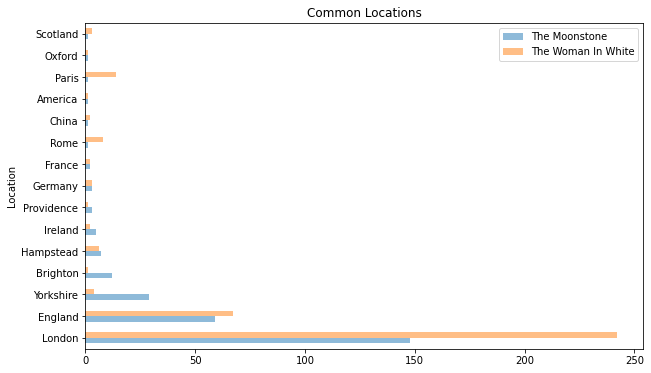

In [9]:
# Common Locations

moonstonePlace = pd.DataFrame(Counter([location.text.title() for location in moonstoneLocation]).most_common(), columns=['Location', 'The Moonstone'])
womanInWhitePlace = pd.DataFrame(Counter([location.text.title() for location in womanInWhiteLocation]).most_common(), columns=['Location', 'The Woman In White'])

womanInWhitePlace = womanInWhitePlace.replace({"St. John'S": "St. John's Wood"})
womanInWhitePlace = womanInWhitePlace.drop([51, 56, 67, 70, 12])

commonPlace = moonstonePlace.merge(womanInWhitePlace).set_index('Location').fillna(0)

commonPlace.plot.barh(alpha=0.5, figsize=(10, 6))
plt.title('Common Locations')
plt.savefig('Common_Locations.png')

In [10]:
tfidVectorizer = TfidfVectorizer(max_features=100)

male = [bruff[1000:4000], franklin[1000:4000], jennings[1000:4000], cuff[1000:4000], 
        candy[1000:4000], betteredge[1000:4000], clack[1000:4000],
        hartright[1000:4000], gilmore[1000:4000], frederick[1000:4000], 
        fosco[1000:4000], halcombe[1000:4000], michelson[1000:4000], 
        pinhorn[1000:4000], catherick[1000:4000]]


names = ['bruff', 'franklin', 'jennings', 'cuff', 'candy', 'betteredge', 'clack',
       'hartright', 'gilmore', 'frederick', 'fosco', 'halcombe', 'michelson',
        'pinhorn', 'catherick']
textMatrix = tfidVectorizer.fit_transform(male)
denseTextMatrix = textMatrix.todense()
denseTextMatrix.shape
pca = PCA(n_components=2)
textPoints = pca.fit_transform(denseTextMatrix)


textDf = pd.DataFrame(textPoints, index=names, columns =['C1', 'C2'])

In [11]:
womenInWhite_male = [hartright]+ [gilmore]+ [frederick] + [doctor] + [fosco]
womenInWhite_female = [halcombe] + [michelson] + [pinhorn] + [jane_gould]+ [catherick]
allGender_womanInWhite = womenInWhite_male + womenInWhite_female

moonstone_male = [bruff] + [franklin]+ [jennings] + [cuff] + [candy]+ [betteredge]
moonstone_female = [clack]
allGender_moonstone = moonstone_male + moonstone_female

bothTexts = allGender_womanInWhite + allGender_moonstone

allGender_tags = []
for i in bothTexts:
    womenInWhite_maleTags = nltk.pos_tag(word_tokenize(i))
    NoPronouns = [(token, tag) for token, tag in womenInWhite_maleTags if tag != 'PRP']
    womenInWhiteNoPronounsTokens = [item[0] for item in NoPronouns]
    a = ' '.join(womenInWhiteNoPronounsTokens)
    allGender_tags += [a]

    
    
textMatrix2 = tfidVectorizer.fit_transform(allGender_tags)
denseTextMatrix2 = textMatrix2.todense()

In [12]:
pca2 = PCA(n_components=2)
textPoints2 = pca.fit_transform(denseTextMatrix2)
textPoints2.shape

(17, 2)

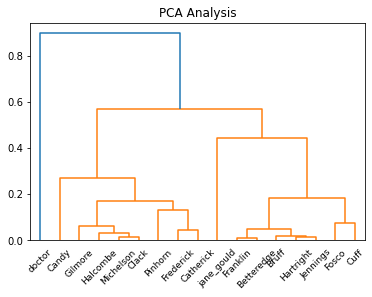

In [13]:
textPoints2.shape
womenInWhite_maleLables = ["Hartright", "Gilmore", "Frederick", "doctor", "Fosco"]
womenInWhite_femaleLables = ["Halcombe", "Michelson", "Pinhorn", "jane_gould","Catherick"]


moonstone_femaleLables = ["Clack"]
moonstone_maleLables = ["Bruff", 'Franklin', 'Jennings', 'Cuff', 'Candy', 'Betteredge']


allGender_label = womenInWhite_maleLables + womenInWhite_femaleLables + moonstone_maleLables + moonstone_femaleLables
textDf2 = pd.DataFrame(textPoints2, index=allGender_label, columns =['C1', 'C2'])

links = linkage(textDf2, method = 'ward')
_ = dendrogram(links,
               leaf_rotation=45,
               leaf_font_size = 9, 
               labels= textDf2.index)
plt.title('PCA Analysis')
plt.savefig('PCA_Analysis.png')

In [14]:
def avg_sentence_length(text):
    words = nltk.word_tokenize(text)
    words = [word.strip(".,!?;()[]#") for word in words]
    sentences = nltk.sent_tokenize(text)
    return len(words)/len(sentences)

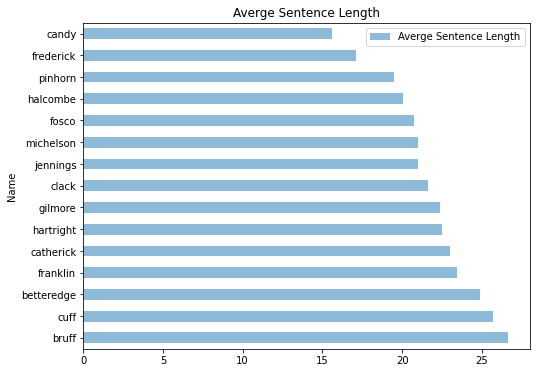

In [15]:
texts = [bruff, franklin, jennings, cuff, 
        candy, betteredge, clack,
        hartright, gilmore, frederick, 
        fosco, halcombe, michelson, 
        pinhorn, catherick]


names = ['bruff', 'franklin', 'jennings', 'cuff', 'candy', 'betteredge', 'clack',
       'hartright', 'gilmore', 'frederick', 'fosco', 'halcombe', 'michelson',
        'pinhorn', 'catherick']

counts = []
for narrator in texts:
    counts.append(avg_sentence_length(narrator))
    
counts

list_of_tuples = list(zip(names, counts))
avg_length = pd.DataFrame(list_of_tuples,
                          columns = ['Name', 'Averge Sentence Length'])
avg_length.index = avg_length['Name']
avg_length = avg_length.sort_values(by='Averge Sentence Length', ascending=False)

avg_length.plot.barh(alpha=0.5, figsize=(8,6))

plt.title('Averge Sentence Length')
plt.savefig('avg_length.png')

In [16]:
womanInWhiteDate = [ent for ent in womanInWhiteDoc.ents if ent.label_ == 'DATE']
womanInWhiteDay = pd.DataFrame(Counter([date.text for date in womanInWhiteDate]).most_common(), columns=['Date', 'The Woman In White'])
W_timeCount = len(womanInWhiteDate) #678

moonstoneDate = [ent for ent in moonstoneDoc.ents if ent.label_ == 'DATE']
moonstoneDay = pd.DataFrame(Counter([date.text for date in moonstoneDate]).most_common(), columns=['Date', 'The Moonstone'])
M_timeCount = len(moonstoneDate) #489
M_timeCount 

print(f"Total Date Elements Count: The Woman In White {W_timeCount}",
     f"Total Date Elements Count: The Moonstone {M_timeCount}", sep="\n")



Total Date Elements Count: The Woman In White 678
Total Date Elements Count: The Moonstone 489


In [17]:
moonstoneDay

,Date,The Moonstone
0,last year,28
1,yesterday,22
2,Monday,19
3,Thursday,19
4,the day,15
...,...,...
246,some three days,1
247,the second day,1
248,the third day,1
249,the third day’s,1


In [18]:
 womanInWhiteDay

,Date,The Woman In White
0,yesterday,49
1,the day,32
2,the next day,25
3,summer,16
4,years,13
...,...,...
338,the next three days,1
339,the\n25th,1
340,the February,1
341,a year later,1


In [19]:
#Distinctive

def counted(textString):
    lowered = textString.lower().replace('–', ' – ')
    lowered = lowered.replace('*', ' ')
    tokens = nltk.word_tokenize(lowered)
    counted = Counter(tokens)
    return counted

def numWords(textString):
    lowered = textString.lower()
    tokens = nltk.word_tokenize(lowered)
    return len(tokens)

def distinctiveWords(narrator, df):
    narr = df[narrator]
    average = df['average']
    distinction = narr - average
    return distinction

def mostDistinctiveWords(distinctiveSeries):
    return distinctiveSeries.sort_values(ascending=False).head(20)

# Moonstone
moonstoneAllNumWords = [numWords(narr) for narr in [betteredge, clack, bruff, franklin, jennings, cuff, candy]]
moonstoneAllCounts = {"Betteredge": counted(betteredge), "Clack": counted(clack), "Bruff": counted(bruff), "Franklin": counted(franklin),
             "Jennings": counted(jennings), "Cuff": counted(cuff), "Candy": counted(candy)}
moonstoneNarratorsDF = pd.DataFrame(moonstoneAllCounts).fillna(0)
moonstoneNarratorsFreqDF = moonstoneNarratorsDF / moonstoneAllNumWords
moonstoneNarratorsFreqDF['average'] = moonstoneNarratorsFreqDF.mean(axis=1)

moonstoneAllLabels = ["Betteredge", "Clack", "Bruff", "Franklin", "Jennings", "Cuff", "Candy"]

moonstone_distintive_df = pd.DataFrame(columns = moonstoneAllLabels)

for label in moonstoneAllLabels:
    each = mostDistinctiveWords(distinctiveWords(label,moonstoneNarratorsFreqDF))
    moonstone_distintive_df[label] = each.index

    
# Woman in White

womanAllNumWords = [numWords(narr) for narr in [hartright, gilmore, halcombe, frederick, michelson, pinhorn, jane_gould, catherick, fosco]]
womanAllCounts = {"Hartright": counted(hartright), "Gilmore": counted(gilmore), "Halcombe": counted(halcombe), "Frederick": counted(frederick),
             "Michelson": counted(michelson), "Pinhorn": counted(pinhorn), "Jane Gould": counted(jane_gould), "Catherick": counted(catherick), "Fosco": counted(fosco)}
womanNarratorsDF = pd.DataFrame(womanAllCounts).fillna(0)
womanNarratorsFreqDF = womanNarratorsDF / womanAllNumWords
womanNarratorsFreqDF['average'] = womanNarratorsFreqDF.mean(axis=1)

womanAllLabels = ["Hartright", "Gilmore", "Halcombe", "Frederick", "Michelson", "Pinhorn", "Jane Gould", "Catherick", "Fosco"]

woman_distintive_df = pd.DataFrame(columns = womanAllLabels)

for label in womanAllLabels:
    each = mostDistinctiveWords(distinctiveWords(label,womanNarratorsFreqDF))
    woman_distintive_df[label] = each.index


In [20]:
woman_distintive_df

,Hartright,Gilmore,Halcombe,Frederick,Michelson,Pinhorn,Jane Gould,Catherick,Fosco
0,the,",",'',i,'',",",the,you,the
1,of,her,``,.,``,he,i,he,of
2,'',fairlie,laura,--,sir,mistress,in,his,my
3,``,'',?,?,her,says,was,my,glyde
4,--,``,is,is,percival,she,coffin,have,on
5,from,miss,you,my,halcombe,and,gould,him,her
6,on,sir,percival,am,she,was,jane,--,anne
7,which,as,me,louis,count,a,.,had,madame
8,;,percival,--,me,dawson,lady,goodricke,as,in
9,we,you,",",of,miss,``,it,was,by


In [21]:
moonstone_distintive_df

,Betteredge,Clack,Bruff,Franklin,Jennings,Cuff,Candy
0,",",her,of,i,blake,the,he
1,her,she,had,you,i,",",.
2,’,my,i,”,betteredge,),his
3,sergeant,i,her,“,.,(,him
4,she,!,in,me,is,mr.,to
5,franklin,rachel,the,?,the,godfrey,–
6,as,aunt,that,had,mr.,ablewhite,me
7,rosanna,?,they,my,him,of,you
8,and,“,their,it,we,luker,will
9,s,”,indians,’,bruff,pounds,my


## Reality-Driven & Character-Driven: *The Woman in White* and *The Moonstone* 

wordcount: 2002

In this computational analysis research project, I decided to choose two works of Wilkie Collins, *The Woman In White* and *The Moonstone*, as corpus. His books were chosen not just due to the reason that they are the books for which Collins is most known to the public. This is also due to the reason that both books are written by using similar storytelling techniques, including multiple narratives, real location setting, and chronology. Although The Moonstone is considered the first modern detective novel and The Woman in White is considered by many scholars to be the early example of a detective novel, in addition to their writing techniques are similar, they are actually divided into two categories: the detective novel (*The Moonstone*) and the sensation novel (*The Woman in White*). In spite of the fact that they are divided into two categories, I would like to argue that they are both reality-driven and character-driven stories.

*The Woman in White* is a mystery novel written by Collins in 1859, belonging to the genre of sensation novel. The novel tells the story of Hartright, a young painter who applies to work as a painting teacher in The Fairlie's home. On the way to his new job , he meets and helps a woman dressed in white who has escaped from the asylum. While teaching, Hartright fell in love with one of his students, Laura Fairlie, and discovered that she resembled the woman in white he met before. However, Hartright and Laura are forced to part because Laura is engaged for a long time, arranged by her father. Laura then marries her fiance, Sir Percival Glyde, who only coveted Laura’s fortune. Sir Percival Glyde and Count Fosco conspired to kill the woman in white, who knew the truth and tried to free Laura from their conspiracy. Sir Percival Glyde and Count Fosco swapped Laura’s and Anne’s (who was the woman in white) identities, sending Laura back as the woman in white (Anne) to the asylum where she suffered memory loss due to shock. But fortunately, Hartright stepped in to save Laura and shatter Sir Percival Glyde and Count Fosco’s conspiracy. Collins describes the story through a few narrators: Walter Hartright, Vincent Gilmore, Marian Halcombe, Frederick Fairlie, Eliza Michelson, Hester Pinhorn, the Doctor, Jane Gould, and Mrs. Catherick.

*The Moonstone*, written in 1868, is the first modern detective novel. The novel is mainly about the mysterious yellow gem (moonstone) of the moon god, which has been passed down from generation to generation in India. When the British colonists invaded India, a corrupt British army officer, Colonel Herncastle, was attracted by the Moonstone’s great wealth and then brought it to England. There is a mystery of the moonstone enchanted, who owns the moonstone who will lose their lives. The three Brahmins from India, as the protectors of the Moonstone, come to Britain from India determined to recover the stolen moonstone. Colonel Herncastle made a will before his death, giving the cursed gem to his niece Rachel (Miss Verinder) as a birthday present. Rachel’s quiet life is shattered when she gets the gem, which disappeared on the night of her birthday. In the process of identifying the thief, a series of strange things happened one after another, and was finally solved by Sergeant Cuff. Similarly to Laura Fairlie in *The Woman in White*, Miss Rachel was also engaged to a man who only coveted for her fortune: Godfrey Ablewhite, Rachel’s cousin. In this book, Collins tells the story through seven narrators: Gabriel Betteredge (Mr. Betteredge), Drusilla Clack (Miss. Clack), Mathew Bruff (Mr. Bruff), Franklin Blake (Mr. Franklin), Ezra Jennings, Sergeant Cuff, and Mr. Candy. 

Wilkie Collins’ multi-narrative writing style first proves that *The Woman in White* and *The Moonstone* are character-driven rather than plot-driven. [The NY Book Editor](https://nybookeditors.com/2017/02/character-driven-vs-plot-driven-best/) explains that a plot-driven story is a full story with a clear goal, even replacing characters would not lead to much change in the plot; The role of the characters in a story is to drive the plot from beginning to end, "As a result, character development is secondary to plot development" (Character-driven vs. plot driven: Which is best). A character-driven story, on the other hand, focuses on “inner transformation or the relationship between the characters,” so the story is made up of characters. In addition, Sue Lonoff's point also affirms the idea that the characters drive the plot. According to her paper “Multiple Narratives & Relative Truths: A Study of *The Ring and The Book*, *The Woman in White*, and *The Moonstone*,” she says, "Nonetheless, although his characters… speak in readily distinguishable voices, their authenticity is of less consequence than their roles of function in the story"(Lonoff 154). Lonoff backs up her argument by analyzing The Verinder's butler Betterage, saying that it’s impossible for a servant chief to have such a personality who had spent his entire life in Yorkshire, England. She further concludes that Betteridge's "chatter supplies the element of humor that Victorian readers expected, and enables him casually to furnish the clues that lead to the solution of the mystery" (Lonoff 154). Therefore, the development of the plot is driven by the characterization of the characters, and the characters' personalities and choices determine the outcome of the story.

To examine Lonoff's first argument that the characters all have different voices, I first found the distinctive words of the narrators by writing functions to calculate the average by using `word_tokensize` of  NLTK and then subtracted the average by the value of each narrator. By finding the distinctive words of the narrator, it means finding words that are used more than the average. I thus sorted out the top 20 most frequently used distinctive words from the distinctive word series and put all the narrators in the same book into the same data frame. Finally, frequency analysis is performed from the output data frames. The following plots show the 20 most frequently used distinctive words for each narrator in *The Woman in White* (plot: `woman_distintive_df`) and *The Moonstone* (`moonstone_distintive_df`). To look at some examples of these outputs. One of Miss Clack’s most distinctive words is "!” The exclamation is reminiscent of Miss Clack’s tone of speaking, with her frequent saying of "Alas!” In addition, Count Fosco's “distinguishable voice” can be seen in his distinctive word of "wife". In *The Woman in White*, Collins makes Count Fosco not only a man who is a tamer for the animals but also a tamer for his wife. Madame Fosco used to be an independent woman with a mind of her own, but she is tamed by Count Fosco and becomes his obedient servant, her every opinion based on her husband's "advice" since her marriage.

Second, to examine Lonoff’s second point, the characters' "authenticity is of less consequence than their roles of function in the story", that is, making up the story. To prove the validity of this argument, I calculated the average sentence length of each character in both books. By comparing and contrasting the bar plot below, Mr. Bruff appears to have the longest average sentence length, while Mr. Candy appears to have the shortest average sentence length. This evidence also serves to Lonoff's first argument, that all characters have "distinguishable voices." Mr. Bruff, as The Verinder's family solicitor, his profession has indeed influenced his speaking style, making it more verbose and precise. And due to his illness, Mr. Candy could not repeat things as clearly and completely as the others, and his sentences fell apart, thus, making him have the shortest average sentence length among all. Despite that, the longest and shortest average sentence lengths were explained to "distinguishable voice", and when comparing the average sentence lengths of adjacent narrators, the differences were fairly small. Mrs. Michelson in The Woman in White and Mr. Jennings in The Moonstone, in particular, seem to have the same average sentence length, even though they are narrators in different books.![avgLengthplot](avg_length.png)

Additionally, to further test the differences between the narrators in both stories, I applied the Principal component analysis (PCA). To explain the PCA visualization, when the longer the length of each vertical line is, the greater the dissimilarity of the text clustering of narrators (Omar 203). Similarly, different line colors indicate that they belong to different clusters of text. By doing this PCA analysis, I used `dendrogram`. In addition, in the picture below, with the exception of the doctor in *The Woman in White*, the text is a short statement confirming the death of "Lady Glyde" (Laura Fairlie), all the narrators in the two books belong to the same color group. This can cause people to question the authenticity of each character. However, this may also be due to the fact that they were all written by the same author. Thus, both average sentence length and PCA applied analysis are in favor of supporting Lognoff's second argument that the character's role in the stories are more significant than their authenticity, which means that both books are character-driven. ![pca](PCA_Analysis.png)

Both *The Woman in White* and *The Moonstone* are reality-driven with respect to the location and time. As for location, both books are described in the context of familiar locations -- English cities such as London, Yorkshire, Brinton, etc. To find the common locations that appear in both *The Woman in White* and *The Moonstone*, I used the `SpaCy` library for natural language processing. And in particular, I applied Named Entity Recognition (NER) techniques to identify and extract locations that appear in both books. After extracting the locations, I add up the total count for each unique location in each book and put them into a separate data frame. Finally, I combined the two data frames based on their common location and plotted them into a barplot for better understanding and visualization. Unlike modern detective novels, *The Woman in White* and *The Moonstone* are set in realistic locations to give readers a sense of reality. When readers read a story, they are able to place themselves in their own familiar environment, thus, they are more easily understood and more connected to the story. In the Common Location bar plot below, the location of "London" appears nearly 250 times in the text of *The Woman in White*; It appears nearly 150 times in *The Moonstone*. ![location](Common_Locations.png)

The second, reality-driven is with respect to time. Although Lonoff states "Collins plays elaborate games with the chronology of The Moonstone, forging two narrative chains congruently, the story of the crime and the story of investigation" (Lonoff 153), Collins not only depicts the story in the chronology, such as "thirteenth day of October 1850" (white) (The Woman in White). Whether he uses all kinds of time fragments to describe the story, weeks (" Monday"), months ("June"), the passage of time ("the next three days"), and so on. Using NER to identify and extract time elements, I found that a total of 678 `ent.label_ == “DATE”` were obtained in *The Woman in White* and a total of 489 `ent.label_ == “DATE”` in *The Moonstone*. Collins enhances the authenticity of the narrators’ narrative by using chronology, or time, to describe the investigation story and by having the reader go back chronologically to events. He also set the stories in the past rather than the future to make them more realistic. In terms of the time of the stories, they all took place before the novel was published.

According to the textual analysis and computational analysis, Wilkie Collins’ works of *The Woman in White* and *The Moonstone* are in greater similarity than in differences in terms of writing styles, writing techniques, and also the theme of investigation. And based on the analysis of *The Woman in White* and *The Moonstone* in this project, the three elements of the stories, multiple narratives, the familiar realistic locations, and the chronology are all part of Wilkie Collins’ writing style in terms of writing detective novels. Wilkie Collins’ writing techniques of reality-driven and character-driven enhance the authenticity of the narrators’ narrative, which is the truthfulness of the event, although they did not enhance the authenticity of characters.





# References

“Character-Driven vs. Plot Driven: Which Is Best.” NY Book Editors, nybookeditors.com/2017/02/character-driven-vs-plot-driven-best/. 

Lonoff, Sue. Multiple Narratives &amp; Relative Truths: A Study of 'the ... www.jstor.org/stable/25057725. 

Omar, A. The Detective and Sensation Fiction of Wilkie Collins. 2020, www.researchgate.net/publication/340089279_The_Detective_and_Sensation_Fiction_of_Wilkie_Collins_A_Computational_Lexical-Semantic_Analysis/fulltext/5e775e064585157b9a51abb4/The-Detective-and-Sensation-Fiction-of-Wilkie-Collins-A-Computational-Lexical-Semantic-Analysis.pdf. 